<a href="https://colab.research.google.com/github/mgstockwell/yahoo_sp500_etl/blob/main/YahooFinanceDataSource.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install yfinance
Original source: https://colab.sandbox.google.com/github/gumdropsteve/intro_to_prophet/blob/master/prophet_yfinance.ipynb

In [ ]:
# https://pypi.org/project/pyodbc/
# https://stackoverflow.com/questions/61519253/pyodbc-on-google-colab
import os, sys

!sudo apt-get update -q
!sudo apt-get upgrade -q
!pip install -q yfinance
!pip3 install pyodbc

!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
!sudo apt-get update

# optional: for bcp and sqlcmd
!sudo ACCEPT_EULA=Y apt-get -q -y install mssql-tools unixodbc-dev
!sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17
!sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql18
!sudo ACCEPT_EULA=Y apt-get -q -y install mssql-tools18
!sudo apt update
!sudo apt-get upgrade

!echo 'export PATH="$PATH:/opt/mssql-tools/bin"' >> /etc/profile
!echo 'export PATH="$PATH:/opt/mssql-tools18/bin"' >> /etc/profile
!echo 'export PATH="$PATH:/opt/microsoft/msodbcsql17/lib64"' >> /etc/profile
!echo 'export PATH="$PATH:/opt/microsoft/msodbcsql18/lib64"' >> /etc/profile
!source /etc/profile

# on Colab this is what works, profile not invoked
!echo 'export PATH="$PATH:/opt/mssql-tools/bin"' >> /etc/environment
!echo 'export PATH="$PATH:/opt/mssql-tools18/bin"' >> /etc/environment
!echo 'export PATH="$PATH:/opt/microsoft/msodbcsql17/lib64"' >> /etc/environment
!echo 'export PATH="$PATH:/opt/microsoft/msodbcsql18/lib64"' >> /etc/environment
!source /etc/environment
sys.path.append("/opt/mssql-tools/bin")
sys.path.append("/opt/mssql-tools18/bin")
sys.path.append("/opt/microsoft/msodbcsql17/lib64")
sys.path.append("/opt/microsoft/msodbcsql18/lib64")
os.environ['PATH'] += ":/opt/mssql-tools18/bin"
os.environ['PATH'] += ":/opt/microsoft/msodbcsql18/lib64"

# ODBC Driver setup/registration
!echo [ODBC Driver 17 for SQL Server] >/etc/odbcinst.ini
!echo Description=Microsoft ODBC Driver 17 for SQL Server >>/etc/odbcinst.ini
!echo Driver=/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.9.so.1.1 >>/etc/odbcinst.ini
!echo UsageCount=1 >>/etc/odbcinst.ini
!echo [ODBC Driver 18 for SQL Server] >>/etc/odbcinst.ini
!echo Description=Microsoft ODBC Driver 18 for SQL Server >>/etc/odbcinst.ini
!echo Driver=/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.0.so.1.1 >>/etc/odbcinst.ini
!echo UsageCount=1 >>/etc/odbcinst.ini

!echo $PATH


# Get list of SP 500
original source: https://tcoil.info/how-to-get-list-of-companies-in-sp-500-with-python/

In [2]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df_sp500 = first_table.convert_dtypes()
df_sp500.convert_dtypes()
df_sp500.to_csv('sp500' + '.csv', index=False)
df_sp500.info()
df_sp500.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    string
 1   Security               503 non-null    string
 2   GICS Sector            503 non-null    string
 3   GICS Sub-Industry      503 non-null    string
 4   Headquarters Location  503 non-null    string
 5   Date added             503 non-null    string
 6   CIK                    503 non-null    Int64 
 7   Founded                503 non-null    string
dtypes: Int64(1), string(7)
memory usage: 32.1 KB


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902


# Get ticker info, dump to CSV

In [ ]:
# Get some data
# https://medium.com/dropout-analytics/prophet-any-stock-in-seconds-5f9479977aea
# https://aroussi.com/post/python-yahoo-finance
import yfinance as yf
import pandas as pd

for t in df_sp500['Symbol']:
  ticker = yf.Ticker(t)
  df = pd.DataFrame([ticker.info],index=[t])
  try:
    # bulk loading with parameterized query only accepts len 510 ascii, UTF double byte
    df["longBusinessSummary"] = df["longBusinessSummary"].str.slice(0, 250)
  except BaseException as err:
    print(f"Unexpected {err}, {type(err)} on {t}")
    continue
  df.index.names = ['ticker']
  df.convert_dtypes()
  df.to_csv('ticker_info_' + t + '.csv')
  print('Finished',t)



# Get Price History, dump to CSV

In [5]:
import yfinance as yf
import pandas as pd
import datetime, time

for t in df_sp500['Symbol']:
  # ticker info
  try:
      a_date = datetime.date.today()
      days = datetime.timedelta(30)
      new_date = a_date - days
      print(f'starting yahoo api call for ticker {t}\n')
      data = yf.download([t], start=new_date, interval="5m", auto_adjust=True)
      print("yahoo call made, returns:\n", data)
      df = pd.DataFrame.from_dict(data)
      print('dataframe made from dict: \n', df)
      df.loc[:,'ticker'] = t
      print('ticker added:\n', df)
      df.reset_index(inplace=True)
      print("index reset:\n", df)
      df.loc[:,'Datetime'] = df['Datetime'].astype(str)
      print('datetime updated:\n', df)
      df2 = df[df['Volume'] > 0]
      print(df2.head())
  except BaseException as err:
      print(f"Unexpected {err}, {type(err)} on {t} in load_price_history")
      print('  First row:', t)
  break



[*********************100%%**********************]  1 of 1 completed

starting yahoo api call for ticker MMM

yahoo call made, returns:
                                 Open       High        Low      Close  Volume
Datetime                                                                     
2024-04-09 09:30:00-04:00  92.099998  92.870003  92.000000  92.781998   93280
2024-04-09 09:35:00-04:00  92.775002  92.849998  92.580002  92.657501   33165
2024-04-09 09:40:00-04:00  92.654999  92.699997  92.340103  92.375000   30613
2024-04-09 09:45:00-04:00  92.377899  92.459999  92.120003  92.160004   31670
2024-04-09 09:50:00-04:00  92.144897  92.287498  92.144897  92.160004   24681
...                              ...        ...        ...        ...     ...
2024-05-08 15:35:00-04:00  96.209999  96.224998  96.099998  96.209999  109120
2024-05-08 15:40:00-04:00  96.218697  96.250000  96.169998  96.250000   62192
2024-05-08 15:45:00-04:00  96.254997  96.294998  96.220001  96.269997   61802
2024-05-08 15:50:00-04:00  96.260002  96.440002  96.235001  96.410004  1664

In [ ]:
import datetime, time
for i in range(10):
  fname = f'{time.time_ns()}_tmp.csv'
  print(time.time_ns(), fname)

# Load data to Azure SQL DB

### Connect to Azure

In [ ]:
import pyodbc
import os

# Obtain connection string information from the portal, copy full string to input
# getpass hides the value from output, secret manager better option
# https://stackoverflow.com/questions/54571009/
# how-to-hide-secret-keys-in-google-colaboratory-from-users-having-the-sharing-lin
from getpass import getpass

folder = '/.azure'
os.makedirs(folder, exist_ok=True)
filepath = os.path.join(folder,'connection.txt')

if os.path.exists(filepath):
  conn_string = open(filepath).read()
else:
  conn_string = getpass('enter full string no beg/end quotes:')
  with open(filepath,'w') as f:
    f.write(conn_string)

# Construct connection string
with pyodbc.connect(conn_string) as conn:
  with conn.cursor() as cursor:
    cursor.execute("SELECT @@Version")
    row = cursor.fetchall()
    print(row)

  # Drop previous table of same name if one exists
  cursor.execute("DROP TABLE IF EXISTS inventory;")
  print("Finished dropping table (if existed).")

  # Create table
  cursor.execute("""CREATE TABLE inventory (
                      id INT NOT NULL IDENTITY PRIMARY KEY,
                      name VARCHAR(50),
                      quantity INTEGER);""")
  print("Finished creating table.")

  # Insert some data into table
  cursor.execute("INSERT INTO inventory (name, quantity) VALUES (?,?);", ("banana", 150))
  print("Inserted",cursor.rowcount,"row(s) of data.")
  cursor.execute("INSERT INTO inventory (name, quantity) VALUES (?,?);", ("orange", 154))
  print("Inserted",cursor.rowcount,"row(s) of data.")
  cursor.execute("INSERT INTO inventory (name, quantity) VALUES (?,?);", ("apple", 100))
  print("Inserted",cursor.rowcount,"row(s) of data.")

  # Cleanup
  conn.commit()
  cursor.close()

print("Done.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/*.csv /content/drive/MyDrive/Northwestern/yahoo_data

## Load data from CSV
Defines function to load from df, then cycles through all csv files, converts to df, loads to Azure.

In [ ]:
import pandas as pd
import datetime

#################################################################    TESTING
def connect_db():
    # Construct connection string
    conn = pyodbc.connect(conn_string)
    cursor = conn.cursor()
    return cursor

def list_sp500():
    # There are 2 tables on the Wikipedia page
    # we want the first table, return the dataframe

    payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    first_table = payload[0]
    second_table = payload[1]

    df_sp500 = first_table.convert_dtypes()
    return df_sp500

def load_from_df(sql_table_name, df: pd.DataFrame):
    '''Loads data to SQL server from dataframe
    '''
    df = df.fillna('0')
    #df.index.names = ['ticker']
    df= df.convert_dtypes()

    # create cursor and set fast execute property
    cursor = connect_db()
    cursor.fast_executemany = True

    # get list of sql columns, replace the spaces, used for insert stmnt
    sql_cols_list_qry = f'''select STRING_AGG(COLUMN_NAME,',') col_list
            from  information_schema.columns
            where table_name='{sql_table_name}'; '''
    cursor.execute(sql_cols_list_qry)
    row = cursor.fetchone()
    col_list = str(row[0])
    col_list = col_list.split(",")
    print('  col_list:' + str(col_list))
    print('  df columns:', df.columns.to_list())

    # select columns from dataframe that are in the sql table
    common_cols = set(col_list) & set(df.columns.to_list())
    print('COMMON COLS:',common_cols)
    col_count = len(common_cols)
    df = df[common_cols]

    # vals is list of question marks for each column for insert stmnt
    vals = ('?,' *(col_count -1) ) + '?'
    col_list = str(common_cols).replace("'",'"')
    col_list = col_list.replace('{','').replace('}','')
    insert_tbl_stmt = f"INSERT INTO {sql_table_name} ({col_list}) values({vals})"
    print("   insert statement:", insert_tbl_stmt)

    # insert rows
    try:
      cursor.executemany(insert_tbl_stmt, df.values.tolist())
      print(f'   {len(df)} rows inserted into {sql_table_name} table', datetime.datetime.now())
    except BaseException as err:
      print(f"   Unexpected {err}, {type(err)}, in load_from_df")
    finally:
      cursor.commit()
      cursor.close()

counter= 0

for file in os.listdir():
  if file.startswith("tickerxxxxxxxxxx_info_"):
    try:
      df = pd.read_csv(file)
      df = df.convert_dtypes()
      load_from_df('ticker5_info',df)
    except BaseException as err:
      print(f"Unexpected {err}, {type(err)} in {file}")

  if file.startswith("price_xxxxxxhistory"):
    try:
      df = pd.read_csv(file)
      df = df.convert_dtypes()
      load_from_df('price5_history',df)
    except BaseException as err:
      print(f"Unexpected {err}, {type(err)} in {file}")
  counter +=1
  print(counter, file)

load_from_df('sp500',list_sp500())

1 .config
2 sp500.csv
3 sample_data
  col_list:['Symbol', 'Security', 'SECfilings', 'GICSSector', 'GICSSub-Industry', 'HeadquartersLocation', 'Datefirstadded', 'CIK', 'Founded']
  df columns: ['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK', 'Founded']
COMMON COLS: {'CIK', 'Security', 'Symbol', 'Founded'}
   insert statement: INSERT INTO sp500 ("CIK", "Security", "Symbol", "Founded") values(?,?,?,?)
   504 rows inserted into sp500 table 2022-06-02 03:46:54.861141


In [ ]:
load_from_df('sp500',df_sp500)
df_sp500

  col_list:['Symbol', 'Security', 'SECfilings', 'GICSSector', 'GICSSub-Industry', 'HeadquartersLocation', 'Datefirstadded', 'CIK', 'Founded']
  df columns: ['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK', 'Founded']
COMMON COLS: {'Founded', 'Security', 'Symbol', 'CIK'}
   insert statement: INSERT INTO sp500 ("Founded", "Security", "Symbol", "CIK") values(?,?,?,?)
   Unexpected ('23000', "[23000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_sp500'. Cannot insert duplicate key in object 'dbo.sp500'. The duplicate key value is (MMM). (2627) (SQLExecute)"), <class 'pyodbc.IntegrityError'>, in load_from_df


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
499,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
502,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


## Combine CSV

In [ ]:
files = os.listdir()
file_list = list()

# Create master file and write headers
all_tickers = open('all_tickers.csv','w')
with open('ticker_info_ABT.csv','r') as f:
  headers = f.readline()
  all_tickers.writelines(headers)

for file in os.listdir():
  if file.startswith("ticker_info_"):
    with open(file) as f:
      lines=f.readlines()
      # this skips header
      all_tickers.writelines(lines[1])

all_tickers.close()

# Pricing
all_prices = open('all_prices.csv','w')
with open('price_history_ABT.csv','r') as f:
  headers = f.readline()
  all_prices.writelines(headers)

for file in os.listdir():
  if file.startswith("price_history"):
    with open(file) as f:
      lines=f.readlines()
      # this skips header
      all_prices.writelines(lines[1:])

all_prices.close()

FileNotFoundError: ignored

## Truncate tables

In [ ]:
# https://www.sqlfeathers.com/2019/08/load-data-to-sql-server-using-python.html
import csv, datetime

# conn string was defined in earlier block

def truncate_table(sql_table_name):
  '''truncates data in SQL server
  '''
  print(f"starting truncate {sql_table_name}....", datetime.datetime.now())
  conn = pyodbc.connect(conn_string)

  # create cursor and set statement
  cursor = conn.cursor()
  truncate_tbl_stmt = f"TRUNCATE TABLE {sql_table_name};"
  print("   Truncate statement:", truncate_tbl_stmt)

  # Truncate the tables
  try:
    cursor.execute(truncate_tbl_stmt)
    conn.commit()
    print(f'   finished truncating table {sql_table_name} ...', datetime.datetime.now())
  except BaseException as err:
    print(f"Unexpected {err}, {type(err)}")
    raise
  finally:
    cursor.close()
    conn.close()

truncate_table('sp500')
truncate_table('ticker_info')
truncate_table('price_history')

starting truncate sp500.... 2022-05-11 03:09:35.157836
   Truncate statement: TRUNCATE TABLE sp500;
   finished truncating table sp500 ... 2022-05-11 03:09:35.278750
starting truncate ticker_info.... 2022-05-11 03:09:35.279670
   Truncate statement: TRUNCATE TABLE ticker_info;
   finished truncating table ticker_info ... 2022-05-11 03:09:35.357011
starting truncate price_history.... 2022-05-11 03:09:35.358248
   Truncate statement: TRUNCATE TABLE price_history;
   finished truncating table price_history ... 2022-05-11 03:09:35.432284


In [ ]:
#############################################################################################  TESTING
import yfinance as yf
def load_price_history():
    # Get data from query strings
    args = {"ticker":"AAPL|GOOG"}
    tickers = args.get("ticker").split("|")
    print("args:" + str(args))

    where_clause =  str(tickers).replace("[","").replace("]","")
    where_clause = f"WHERE ticker in ({where_clause})"
    #delete_table('price_history', where_clause)

    # load the tmp table, then compare to main table and insert the new rows
    for t in tickers:
        # ticker info
        try:
            data = yf.download(tickers, period="1mo", interval="5m", auto_adjust=True)
            #display(data)
            df = pd.DataFrame.from_dict(data)
            df.columns = df.columns.to_flat_index()
            display((df))
        except BaseException as err:
            print(f"Unexpected {err}, {type(err)} on {t} in load_price_history")

        df['ticker']= t
        df = df.convert_dtypes()
        #df.reset_index(inplace=True)
        # dumping to csv and reloading seems to solve many problems
        #df.to_csv('tmp.csv')
        #df = pd.read_csv('tmp.csv')
        #display(df)
        df.to_csv('junk.csv')

load_price_history()

args:{'ticker': 'AAPL|GOOG'}
[*********************100%***********************]  2 of 2 completed


,"(Close, AAPL)","(Close, GOOG)","(High, AAPL)","(High, GOOG)","(Low, AAPL)","(Low, GOOG)","(Open, AAPL)","(Open, GOOG)","(Volume, AAPL)","(Volume, GOOG)"
Datetime,,,,,,,,,,
2022-04-13 09:30:00-04:00,167.082596,2572.000000,167.679993,2577.229980,166.865005,2568.771973,167.509995,2572.530029,3525319,44624
2022-04-13 09:35:00-04:00,167.591095,2571.310059,167.809998,2576.084961,167.259995,2571.000000,167.395004,2572.000000,1594972,24212
2022-04-13 09:40:00-04:00,167.979996,2576.104980,168.000000,2577.649902,167.139999,2570.020020,167.339905,2570.020020,1586454,21059
2022-04-13 09:45:00-04:00,168.129303,2580.810059,168.440002,2581.250000,168.110001,2576.814941,168.110001,2576.814941,1196167,18476
2022-04-13 09:50:00-04:00,168.250000,2582.000000,168.460007,2582.000000,167.970001,2576.040039,168.125000,2580.889893,1148431,15825
...,...,...,...,...,...,...,...,...,...,...
2022-05-12 15:40:00-04:00,140.970001,2248.139893,141.800003,2257.149902,140.710007,2244.739990,141.309998,2252.929932,2230821,17272
2022-05-12 15:45:00-04:00,141.110001,2244.399902,141.599899,2252.965088,140.759995,2244.040039,140.949997,2248.489990,2270844,22518
2022-05-12 15:50:00-04:00,141.839996,2254.489990,142.169998,2258.979980,141.119904,2246.689941,141.119904,2246.689941,4143577,42423


[*********************100%***********************]  2 of 2 completed


,"(Close, AAPL)","(Close, GOOG)","(High, AAPL)","(High, GOOG)","(Low, AAPL)","(Low, GOOG)","(Open, AAPL)","(Open, GOOG)","(Volume, AAPL)","(Volume, GOOG)"
Datetime,,,,,,,,,,
2022-04-13 09:30:00-04:00,167.082596,2572.000000,167.679993,2577.229980,166.865005,2568.771973,167.509995,2572.530029,3525319,44624
2022-04-13 09:35:00-04:00,167.591095,2571.310059,167.809998,2576.084961,167.259995,2571.000000,167.395004,2572.000000,1594972,24212
2022-04-13 09:40:00-04:00,167.979996,2576.104980,168.000000,2577.649902,167.139999,2570.020020,167.339905,2570.020020,1586454,21059
2022-04-13 09:45:00-04:00,168.129303,2580.810059,168.440002,2581.250000,168.110001,2576.814941,168.110001,2576.814941,1196167,18476
2022-04-13 09:50:00-04:00,168.250000,2582.000000,168.460007,2582.000000,167.970001,2576.040039,168.125000,2580.889893,1148431,15825
...,...,...,...,...,...,...,...,...,...,...
2022-05-12 15:40:00-04:00,140.970001,2248.139893,141.800003,2257.149902,140.710007,2244.739990,141.309998,2252.929932,2230821,17272
2022-05-12 15:45:00-04:00,141.110001,2244.399902,141.599899,2252.965088,140.759995,2244.040039,140.949997,2248.489990,2270844,22518
2022-05-12 15:50:00-04:00,141.839996,2254.489990,142.169998,2258.979980,141.119904,2246.689941,141.119904,2246.689941,4143577,42423


### Load SP 500 and Ticker data

In [ ]:
%%timeit
import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
ticker_info = msft.info
ticker_financials = msft.financials.transpose()
ticker_financials.to_csv('junk.csv')
print(ticker_financials)
print(ticker.news)

junk = \
'''
# get historical market data
hist = msft.history(period="max")

# show actions (dividends, splits)
msft.actions

# show dividends
msft.dividends

# show splits
msft.splits

# show financials
msft.financials
msft.quarterly_financials

# show major holders
msft.major_holders

# show institutional holders
msft.institutional_holders

# show balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet

# show cashflow
msft.cashflow
msft.quarterly_cashflow

# show earnings
msft.earnings
msft.quarterly_earnings

# show sustainability
msft.sustainability

# show analysts recommendations
msft.recommendations

# show next event (earnings, etc)
msft.calendar

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# show news
msft.news

# get option chain for specific expiration
opt = msft.option_chain('YYYY-MM-DD')
# data available via: opt.calls, opt.puts
'''

# Forecasting Stocks from Yahoo Finance with Prophet

In [ ]:
from fbprophet import Prophet

m = Prophet(daily_seasonality=False)

m.fit(df)

NameError: ignored

In [ ]:
future = m.make_future_dataframe(365, freq='D')

forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
m.plot(forecast);

## Make it a Function

In [ ]:
def make_forecast(ticker, periods, hist='max'):
    """
    forecast the given ticker (stock) period days into the future (from today)

    inputs
    ------
    > ticker
        >> ticker of stock to forecast
    > periods
        >> number of days into the future to forecast (from today's date)
    > hist
        >> amount of historical data to consider
            > default: max
            > options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
    """
    # pull historical data from yahoo finance
    stock_data = yf.Ticker(ticker)

    hist_data = stock_data.history(hist, auto_adjust=True)

    # create new dataframe to hold dates (ds) & adjusted closing prices (y)
    df = pd.DataFrame()

    df['ds'] = hist_data.index.values
    df['y'] = hist_data['Close'].values

    # create a Prophet model from that data
    m = Prophet(daily_seasonality=False)
    m.fit(df)

    future = m.make_future_dataframe(periods, freq='D')

    forecast = m.predict(future)

    m.plot(forecast)

    return forecast

### Make some Forecasts with that Function

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-05-06,19.540001,19.540001,19.540001,19.540001,19.540001,0.0,0.0,0.0,0.0,0.0,0.0,19.540001
1,2022-05-09,18.870001,18.870001,18.870001,18.870001,18.870001,0.0,0.0,0.0,0.0,0.0,0.0,18.870001
2,2022-05-10,18.930000,18.930000,18.930000,18.930000,18.930000,0.0,0.0,0.0,0.0,0.0,0.0,18.930000
3,2022-05-11,18.879999,18.879999,18.879999,18.879999,18.879999,0.0,0.0,0.0,0.0,0.0,0.0,18.879999
4,2022-05-12,18.860001,18.860001,18.860001,18.860001,18.860001,0.0,0.0,0.0,0.0,0.0,0.0,18.860001
5,2022-05-13,18.840002,18.800712,18.884419,18.800712,18.884419,0.0,0.0,0.0,0.0,0.0,0.0,18.840002


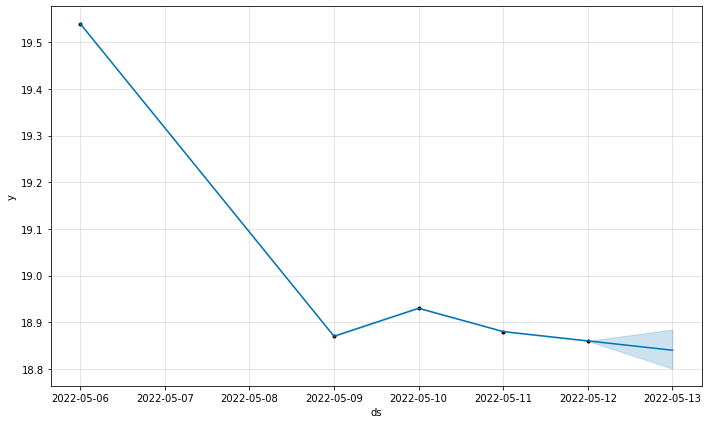

In [ ]:
# kkr real estate finance trust
make_forecast('KREF', 1, '5d')

In [ ]:
# dave & buster's
make_forecast('PLAY', 365 * 2).tail()

In [ ]:
n = 1  # set variable for number of days to predict

# snapchat
snap_forecast = make_forecast('SNAP', n)

# only keep the future forecast, and forget most columns
snap_forecast = snap_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(n)

snap_forecast